<a href="https://colab.research.google.com/github/JayAhn0104/Kaggle/blob/main/Tabular_data/Classification/Titanic/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendations

This notebook is written in google colab.

To see some interactive plots, please enter the colab link above.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview

This notebook provides the 'proper workflow' for kaggle submission.

The workflow is divided into three main steps.
1. Data preprocessing
2. Model selection (hyper parameter tuning, model combination, model comparison)
3. Training final model & Prediction on Test-set

At each stage, detailed descriptions of the work and an appropriate procedure will be provided.

Through this notebook, readers can learn the 'proper workflow' to be done for kaggle submission, 
and using this as a basic structure, someone will be able to apply this to other competitions easily with some adjustments

**Warnings**:
- The purpose of this notebook
  - This notebook focuses on the 'procedure' rather than the 'result'. 
  - Thus ths notebook does not guide you on how to achieve the top score. Since I personally think that any result can only have meaning through an appropriate procedure.
  - However, following this notebook, you will get the top 5% result in titanic kaggle competition

- The readers this notebook assumes
  - Who are aware of the basic usage of data processing tools (e.g., numpy, pandas)
  - Who are aware of the basic concepts of machine learning models 



# 0. Configuration

Set the configurations for this notebook

In [ ]:
config = {
    'data_name': 'Titanic',
    'random_state': 2022
}

# 1. Data preprocessing

The data preprocessing works are divided into 8 steps here.

Some of these steps are mandatory and some are optional.

Optional steps are marked separately.

It is important to go through each step in order.
Be careful not to reverse the order.

## 1-1. Load Dataset

Load train-set and test-set on working environment

In [ ]:
import numpy as np
import pandas as pd
import os

train = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/train.csv'.format(config['data_name']))
test = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/test.csv'.format(config['data_name']))

### > Concatenate the 'train' and 'test' data for preprocessing

Data preprocessing work should be applied equally for train-set and test-set.

In order to work at once, exclude the response variable 'Survived' from 'train' and combine it with 'test'.

In [ ]:
all_features = pd.concat((train.drop(['Survived'], axis=1), test), axis=0)

## 1-2. Missing Value Treatment

Missing (NA) values in Data must be treated properly before model training.

There are three main treatment methods:
1. Remove the variables which have NA values
2. Remove the rows (observations) which have NA values
3. Impute the NA values with other values

Which of the above methods is chosen is at the analyst's discretion.
It is important to choose the appropriate method for the situation.

### > Missing value 확인

Four variables (Age, Fare, Cabin, Embarked) have NA values

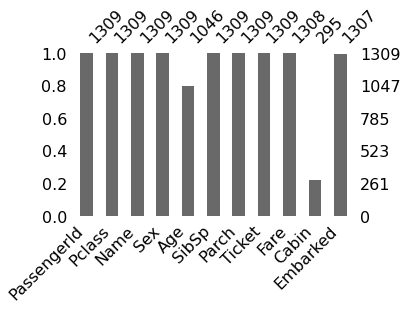

In [ ]:
import missingno as msno
msno.bar(all_features, figsize=(5, 3))

#### >> Embarked
- Method: Replace NA in 'Embarked' by mode value of 'Embarked' grouped by 'Pclass'



The figure below shows that the distribution of 'Embarked' is different according to the Pclass.

In [ ]:
dfg = all_features.groupby(['Pclass', 'Embarked']).size().reset_index()
dfg = dfg.rename(columns={0: 'Count'})

import plotly.express as px
px.bar(dfg, x='Pclass', y='Count', color='Embarked', width=400, height=400)

In [ ]:
# Impute NA values in 'Embarked' by mode value of 'Embarked' grouped by 'Pcalss'
all_features['Embarked'] = all_features['Embarked'].fillna(all_features.groupby(['Pclass'])['Embarked'].transform(lambda x:x.value_counts().index[0]))

#### >> Fare
- Method: Replace NA in 'Fare' by **median** value of 'Fare' grouped by 'Pclass'

The figure below shows that the distribution of Fare is different depending on the Pclass.

(An ANOVA test is used to determine whether the differences between groups are significant.)


In [ ]:
x = 'Pclass'
y = 'Fare'

import plotly.express as px
fig = px.box(all_features, x=x, y=y, color=x, width=400, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('{} ~ {}'.format(y, x), data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                sum_sq      df           F         PR(>F)
Pclass    1.092668e+06     1.0  592.438099  3.266268e-108
Residual  2.408732e+06  1306.0         NaN            NaN


In [ ]:
all_features['Fare'] = all_features['Fare'].fillna(all_features.groupby('Pclass')['Fare'].transform('median'))

#### >> Age
- Method: Replace NA in 'Age' by **median** value of 'Age' grouped by 'Title'

  - To do so, we need to create the 'Title' extract from the 'Name'

In [ ]:
# Extract Title from Name
all_features['Title'] = all_features['Name'].str.split('.').str[0].str.split(',').str[1].str.strip()

# 비슷한 의미의 title을 합쳐준다
title_Mr = ['Major', 'Col', 'Sir', 'Don', 'Jonkheer', 'Capt']
title_Mrs = ['Lady', 'the Countess', 'Dona']
title_Miss = ['Mlle', 'Mme', 'Ms']

all_features.replace(title_Mr, 'Mr', inplace=True)
all_features.replace(title_Mrs, 'Mrs', inplace=True)
all_features.replace(title_Miss, 'Miss', inplace=True)

The figure below shows that the distribution of Age is different depending on the Title.

(An ANOVA test is used to determine whether the differences between groups are significant.)

In [ ]:
x = 'Title'
y = 'Age'

import plotly.express as px
fig = px.box(all_features, x=x, y=y, color=x, width=400, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('{} ~ {}'.format(y, x), data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df          F        PR(>F)
Title      60904.737001     5.0  81.106106  5.892327e-72
Residual  156192.744945  1040.0        NaN           NaN


In [ ]:
# Impute NA values in 'Age' by mode value of 'Age' grouped by 'Title'
all_features['Age'] = all_features['Age'].fillna(all_features.groupby('Title')['Age'].transform('median'))

#### >> Cabin
- method: Drop the variable
  - because there are too many NA values (1014 out of 1309) in 'Cabin'

In [ ]:
all_features.drop('Cabin', axis=1, inplace=True)

### > Check missing values again

Make sure there is no NA value in the whole data

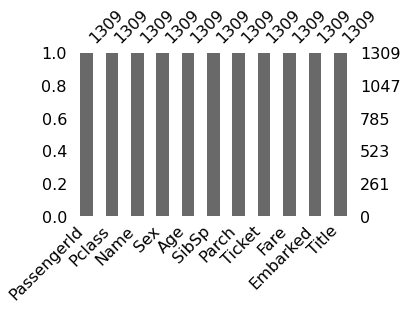

In [ ]:
import missingno as msno
msno.bar(all_features, figsize=(5, 3))

In [ ]:
not all_features.isnull().sum().any()

True

## 1-3. Adding New Features (*optional*)

New variables can be created using the given data.
These variables are called 'derived variables'.

New informations can be added by creating appropriate derived variables.

This can have a positive effect on model performance. (Not always)


### > Insights from data

Through the observations below, if the ticket value is the same, it can be confirmed that the Fare is also the same.

Also via SibSp, Parch we can find out whether the passenger has a family or no

From the example below, it can be inferred that a family of three sharing the name 'Taussig' had boarded on the boat together.

Mr. Emil would be a husband, Mrs. Emil would be spouse. Miss. Ruth would be their child.

But the information that they are a group is not included in the data!


This information might have a positive effect on model performance

In [ ]:
all_features[all_features['Ticket']=='110413']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
262,263,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,S,Mr
558,559,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,S,Mrs
585,586,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,S,Miss


Even though 'SibSp' & 'Parch' = 0, we can observe the case that Ticket and Fare match.

In this case, we can think of it as a group of friends or colleagues rather than family.

In [ ]:
all_features[all_features['Ticket']=='110152']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
257,258,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,S,Miss
504,505,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,S,Miss
759,760,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,S,Mrs


### > Create two derived variables


Based on the above observations, two additional variables are created.
- Group_type: indicates the group type of the passenger
- Group_size: indicates the size of the group

In [ ]:
# Specify a count equal to the ticket number of each passenger as the 'Ticket_count' variable.
all_features['Ticket_count'] = all_features.groupby('Ticket')['Ticket'].transform('count')
# Specify a count equal to the Fare value of each passenger as the 'Fare_count' variable.
all_features['Fare_count'] = all_features.groupby('Fare')['Fare'].transform('count')

In [ ]:
all_features[['Group_type','Group_size']]=None

# Assign the value of the Group_type variable based on specific conditions.

# 1. If SibSp + Parch > 0, Then Group_type = 'Family'
all_features.loc[all_features['SibSp'] + all_features['Parch'] > 0, 'Group_type'] = 'Family'
# 2. If SibSp + Parch = 0, Then Group_type = 'Single'
all_features.loc[all_features['SibSp'] + all_features['Parch'] == 0, 'Group_type'] = 'Single'
# 3. If (SibSp + Parch = 0) & (Ticket_count > 0) & (Fare_count > 0) , Then Group_type = 'Ticket'
all_features.loc[(all_features['SibSp'] + all_features['Parch'] ==0) & 
                 (all_features['Ticket_count']>1) & 
                 (all_features['Fare_count']>1), 'Group_type'] = 'Ticket'

In [ ]:
# Assign the value of the Group_size variable based on specific conditions.

# 1. If Group_type=='Family', Then Group_size = 1+ SibSp + Parch
all_features.loc[all_features['Group_type']=='Family','Group_size'] = 1 + all_features.loc[all_features['Group_type']=='Family', ['SibSp', 'Parch']].sum(axis=1) 
# 1. If Group_type=='Single', Then Group_size = 1
all_features.loc[all_features['Group_type']=='Single','Group_size'] = 1
  # 1. If Group_type=='Ticket', Then Group_size = Ticket_count
all_features.loc[all_features['Group_type']=='Ticket','Group_size'] = all_features.loc[all_features['Group_type']=='Ticket','Ticket_count']


## 1-4. Drop Variables that will not be used
Drop 'PassengerId', 'Name', 'Ticket', 'Ticket_count', 'Fare_count'

In [ ]:
all_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_count,Fare_count,Group_type,Group_size
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,18,Family,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,2,Family,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,23,Single,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,6,Family,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,1,61,Single,1


In [ ]:
all_features.drop(['PassengerId', 'Name', 'Ticket', 'Ticket_count', 'Fare_count'], axis=1, inplace=True)

## 1-5. Variable (type) transformation
Specify the data type that matches the characteristics of the variable.

In [ ]:
all_features.dtypes

Pclass          int64
Sex            object
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Title          object
Group_type     object
Group_size     object
dtype: object

In [ ]:
# int -> object
all_features[['Pclass']] = all_features[['Pclass']].astype('object')

# object -> int
all_features['Group_size'] = all_features['Group_size'].astype('int64')

## 1-6. Dummify categorical variables

In the case of linear modeling without regularization, the first or last column should be dropped (to prevent linear dependency), but here, for the convenience of using the factorization model, one-hot encoding method is used that does not drop any columns.

In [ ]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1-7. Scaling continuous variables

The float variables 'Age' and 'Fare' were measured in different units.
MinMaxScaling maps all variables from 0 to 1 in order to consider only relative information, not absolute magnitudes of values.

Besides, it is known that scaling is often more stable in parameter optimization when training a model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1-8. Split Train & Test set

In [ ]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype(np.float32)
X_test = data_set[n_train:].astype(np.float32)
y_train = train['Survived'].values.astype(np.int64)

print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of X_test: {}'.format(X_test.shape))

Shape of X_train: (891, 22)
Shape of X_test: (418, 22)


## 1-9. Outlier Detection on Training data (*optional*)

Detect and remove outlier observations that exist in the train-set.

- Methodology: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - How it works
    - Isolation Forest applies a decision tree that repeats splits based on the 'random criterion' for the given data unitl only one observation remains in every terminal node (this is defined as 'isolation').
    - Based on the number of splits used for isolation, 'normality' is defined. A smaller value means a higher degree of outlierness.
    - By applying this decision tree several times, the average of the measured 'normality' values ​​is derived as the final 'normality' value.
  - Assumptions
    - Outliers require relatively few splits to be isolated.
    - For normal data, the number of splits required to be isolated is relatively large.
  - Outlier determination
    - Determines whether it is an outlier or not based on the measured 'normality' value.
      - sklearn's IsolationForest package determines based on '0' 
      - I, personally, think it is better to set the discriminant criterion by considering the 'distribution' of the 'normality' values.
      - The details of the method is given below.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=config['random_state'])

clf.fit(X_train)
normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])

The discriminant value (threshold) is defined by calculating the 1st quartile ($q_1$) and 3rd quartile ($q_3$) on the distribution of the measured normality values.

$threshold = q_1 - k*(q_3 - q_1)$

- In this case, set $k=1.5$.

This discriminant method is adapted from Tukey's boxplot idea.
In the distribution of any continuous variable, Tukey designates observations smaller than that value or larger than q_3 + k*(q_3 - q_1) as outliers.

Our methodology does not apply the above method to a specific variable, but applies the method to the obtained normality.

That is, it is based on the assumption that an outlier will be far left from the other observations in the measured normality distribution.

In [ ]:
def outlier_threshold(normality, k=1.5):
  q1 = np.quantile(normality, 0.25)
  q3 = np.quantile(normality, 0.75)  
  threshold = q1 - k*(q3-q1)
  return threshold

threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

fig = px.histogram(normality_df, x='normality', width=400, height=400)
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [ ]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

Only observations whose normality value is greater than the threshold are left in the train-set.

In [ ]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0]))

0 observations are removed from train_set



# 2. Model Selection

Our goal is to build a model that predicts the probability of survival (y=1) given information about a passenger (x). The formula can be expressed as:

$Pr(Y=1|X=x)$

This is a typical binary classification problem, and various machine learning models can be used. This notebook uses the following models.
- Logistic regression
- Support vector machine
- Random forest
- Xgboost
- Multi-layer perceptron
- Factorization

However, we have to "choose" one final methodology to make predictions on the test set.
To do this, a “fair evaluation” of the models is essential. "Fair evaluation" must satisfy the following two conditions.

1. Select optimal hyperparameters for each model
  - If hyperparameter search is not performed, the difference in model performance may occur due to incorrect hyperparameter values.
2. same evaluation method
  - If the same evaluation method is not applied, comparison between models itself is impossible.

When comparing models through an evaluation method that satisfies the above two conditions,
Only then can the final model be selected.




## 2-1. Hyper parameter tuning by using Tune_SKlearn (Ray Tune)


- Package: tune_sklearn
  - This package makes it easy to apply [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to sklearn models.
  - Ray Tune is a python package that provides various hyperparameter tuning algorithms (HyperOpt, BayesianOptimization, ...).
- Tuning procedure
  - Define an appropriate search space for each model's hyperparameters.
  - 5-fold CV (Cross Validation) is performed for each specific hyper-parameter value combination of the search space by using the hyper-parameter tuning algorithm (HyperOpt)
    - Training: Training by using Scikit-Learn and Skorch packages
    - Validation: Evaluate the model using an appropriate evaluation metric
  - The hyperparameter with the highest average score of the CV result is designated as the optimal hyperparameter of the model.
    - Save this CV result and use for model comparison



### > Install Packages

In [ ]:
! pip install tune_sklearn ray[tune] skorch

### > Make a dataframe for containing CV results

In [ ]:
model_list = []
for name in ['linear', 'svm', 'rf', 'xgb', 'mlp', 'fm']:
  model_list.append(np.full(5, name))
  
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'log_loss':None, 'accuracy':None, 'best_hyper_param':None})

### > Logistic regression

In [ ]:
from tune_sklearn import TuneGridSearchCV
from sklearn.linear_model import SGDClassifier

# Define a search space
parameters = {
    'max_iter': [1000],
    'loss': ['log'],
    'penalty': ['l2'],
    'random_state': [config['random_state']],
    'alpha': [1e-9, 1e-8, 1e-7, 1e-6],
}

# Specify the hyper parameter tuning algorithm
tune_search = TuneGridSearchCV(
    SGDClassifier(),
    parameters,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy', # target metric of competition
    verbose=1
    )

# Run hyper parameter tuning
X = X_train 
y = y_train
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'linear'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > Support vector machine

In [ ]:
from tune_sklearn import TuneGridSearchCV
from sklearn.linear_model import SGDClassifier

# Search space를 정의한다
parameters = {
    'max_iter': [1000],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'random_state': [config['random_state']],
    'alpha': [1e-9, 1e-8, 1e-7],
    'epsilon': [1e-9, 1e-8],    
}

# 하이퍼 파라미터 튜닝 알고리즘을 정의한다
tune_search = TuneGridSearchCV(
    SGDClassifier(),
    parameters,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy', # target metric of competition
    verbose=1
    )

# 하이퍼 파라미터 튜닝을 진행한다
X = X_train 
y = y_train
tune_search.fit(X, y)

# 튜닝 결과를 저장한다 
model_name = 'svm'

## 최적 하이퍼 파라미터
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## CV 결과 값
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# 튜닝 결과를 parallel coordinate plot으로 시각화한다
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > Random forest

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestClassifier

# Search space를 정의한다
parameters = {
    'max_features': ['auto'],
    'random_state': [config['random_state']],
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],    
}

# 하이퍼 파라미터 튜닝 알고리즘을 정의한다
tune_search = TuneSearchCV(
    RandomForestClassifier(),
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy',
    verbose=1,
    random_state=config['random_state']
    )

# 하이퍼 파라미터 튜닝을 진행한다
X = X_train 
y = y_train
tune_search.fit(X, y)

# 튜닝 결과를 저장한다 
model_name = 'rf'

## 최적 하이퍼 파라미터
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## CV 결과 값
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# 튜닝 결과를 parallel coordinate plot으로 시각화한다
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > XGBoost

In [ ]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier

# Search space를 정의한다
parameters = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 2],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [10, 15, 20],
    'objective': ['binary:logistic'],
    'random_state': [config['random_state']]
}

# 하이퍼 파라미터 튜닝 알고리즘을 정의한다
tune_search = TuneSearchCV(
    XGBClassifier(),
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy',
    verbose=1,
    random_state=config['random_state']
    )

# 하이퍼 파라미터 튜닝을 진행한다
X = X_train 
y = y_train
tune_search.fit(X, y)

# 튜닝 결과를 저장한다 
model_name = 'xgb'

## 최적 하이퍼 파라미터
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## CV 결과 값
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# 튜닝 결과를 parallel coordinate plot으로 시각화한다
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > Multi-layer perceptron

In [ ]:
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV

# 모형 구조 정의
class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=len(np.unique(y_train)), layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

# 모형 세부사항 정의 
mlp = NeuralNetClassifier(
    MLP(num_inputs=X_train.shape[1], num_outputs=len(np.unique(y_train))),
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-4, lower_is_better=True),
               Checkpoint(monitor='valid_loss_best')]
                          )

# Search space를 정의한다
parameters = {
    'lr': list(np.geomspace(1e-4, 1e-1, 4)),
    'module__layer1': [128, 256, 512],
    'module__layer2': [128, 256, 512],
    'module__dropout1': [0, 0.1],
    'module__dropout2': [0, 0.1],
    'optimizer__weight_decay': list(np.geomspace(1e-5, 1e-1, 5)),
    'max_epochs': [1000],
    'batch_size': [32, 64, 128]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

# 하이퍼 파라미터 튜닝 알고리즘을 정의한다
tune_search = TuneSearchCV(
    mlp, 
    parameters, 
    search_optimization='hyperopt',
    n_trials=15,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy',
    mode='max',   
    use_gpu = use_gpu(try_gpu()),
    random_state=config['random_state'],
    verbose=1,
    )

# 하이퍼 파라미터 튜닝을 진행한다
X = X_train 
y = y_train
tune_search.fit(X_train, y_train)

# 결과 저장
model_name = 'mlp'
## 1. 최적 하이퍼 파라미터 저장
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)
## 2. 최적 하이퍼 파라미터의 CV 결과 저장
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# 하이퍼 파라미터 튜닝 결과 parallel coordinate plot으로 시각화
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df.rename({
    'callbacks__EarlyStopping__threshold':'Earlystoping_threshold',
    'optimizer__weight_decay': 'weight_decay'
    }, axis=1, inplace=True)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > Factorization Machine

#### > Preprocessing Data for implementing Factorization Machine

Since the factorization machine uses an embedding layer, it requires that the data type of all input variables be 'int'.

To take this into account, 'float' type variables are divided into several sections according to their values, and values ​​belonging to a specific section are transformed into interger values ​​of the section.

In [ ]:
def prepro_for_fm(X_train, X_test, bin_method='sturges'):
  n_train = X_train.shape[0]
  all = np.vstack((X_train, X_test))

  col_num_uniq = np.apply_along_axis(lambda x: len(np.unique(x)), 0,  all)
  remain_iidx = (col_num_uniq<=2)
  to_bin_iidx = (col_num_uniq>2)

  all_remain = all[:,remain_iidx]
  all_to_bin = all[:,to_bin_iidx]
  
  for iter in range(all_to_bin.shape[1]):
    bin_size = len(np.histogram(all_to_bin[:,iter], bins=bin_method)[0])
    all_to_bin[:,iter] = pd.cut(all_to_bin[:,iter], bins=bin_size, labels=False)

  all_to_bin_df = pd.DataFrame(all_to_bin).astype('object')
  all_to_bin_array = pd.get_dummies(all_to_bin_df, drop_first=False).to_numpy()

  all_array = np.hstack((all_to_bin_array, all_remain)).astype(np.int64)
  field_dims = all_array.shape[1]
  all_fm = np.vstack((np.apply_along_axis(lambda x: np.where(x==1), 1, all_array)))

  return all_fm[:n_train], all_fm[n_train:], field_dims


X_train_fm, X_test_fm, field_dims = prepro_for_fm(X_train, X_test, bin_method='sturges')

In [ ]:
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV

# 모형 구조 정의
class FM(nn.Module):
    def __init__(self, num_inputs=100, num_factors=20, output_dim=1):
        super(FM, self).__init__()
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))

    def forward(self, x):
        square_of_sum = torch.sum(self.embedding(x), dim=1)**2
        sum_of_square = torch.sum(self.embedding(x)**2, dim=1)
        x = self.bias + self.fc(x).sum(1) + 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)
        return x 

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

# 모형 세부사항 정의 
fm = NeuralNetClassifier(
    FM(num_inputs=field_dims, num_factors=20, output_dim=1),
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-4, lower_is_better=True),
               Checkpoint(monitor='valid_loss_best')]
                          )

# Search space를 정의한다
parameters = {
    'lr': list(np.geomspace(1e-3, 1, 4)),
    'module__num_factors': [20, 50, 100, 150],
    'optimizer__weight_decay': [0.05, 0.1, 0.5, 1],
    'max_epochs': [1000],
    'batch_size': [32, 64, 128]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

# 하이퍼 파라미터 튜닝 알고리즘을 정의한다
tune_search = TuneSearchCV(
    fm, 
    parameters, 
    search_optimization='hyperopt',
    n_trials=14,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=5,
    refit='accuracy',
    mode='max',   
    use_gpu = use_gpu(try_gpu()),
    random_state=config['random_state'],
    verbose=1,
    )

# 하이퍼 파라미터 튜닝을 진행한다
X = X_train_fm
y = y_train.reshape(-1,1).astype('float32') # nn.BCELosswithLogitsLoss는 float type에 대해서 연산이 가능하다
tune_search.fit(X_train, y_train)

# 결과 저장
model_name = 'mlp'
## 1. 최적 하이퍼 파라미터 저장
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)
## 2. 최적 하이퍼 파라미터의 CV 결과 저장
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_loss'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[5:10]

# 하이퍼 파라미터 튜닝 결과 parallel coordinate plot으로 시각화
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df.rename({
    'callbacks__EarlyStopping__threshold':'Earlystoping_threshold',
    'optimizer__weight_decay': 'weight_decay'
    }, axis=1, inplace=True)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_accuracy')
fig.show()

### > Save CV results

In [ ]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results.csv')
best_cv_df.to_csv(file_path, index=False)

In [ ]:
best_cv_df = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Result/best_cv_results.csv'.format(config['data_name']))

## 2-2. Model Comparison based on CV results

Compare the CV results (measured using the optimal hyper parameter values)

The figure below shows that the rf, xgb, mlp, and fm models show superior performance compared to the linear and svm models.



In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

## 2-3. Model Combination

Although it is possible to select a final model based on the above results, it has been observed that in many cases the combination of predicted values ​​from multiple models leads to improve prediction performance. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

For classification problems, the final probabilities are derived by combining the predicted 'probabilities' for each class in a 'proper way'.

This notebook uses following two model combination methods.

1. Simple Average
2. Stacked Generalization (Stacking)


Model comparison needs to be compared with single models (e.g., rf, xgb,...).
So model performance are measured by applying the same CV method as above.

### > Simple Average

The simple average method derives the final probability value by 'averaging' the predicted probability values ​​for each class of multiple models.

The top 4 models (rf, xgb, mlp, fm) of the above CV results are selected as base estimators used for the combination of predicted values.

For example,
- Base Estimations
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
  - $P_{fm}(Y=1|X=x)$ = 0.80
- Final Estimation
  - $P_{average}(Y=1|X=x)$  = 0.8 (= 0.75 + 0.80 + 0.85 + 0.80 / 4)


In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

def CV_ensemble(ensemble_name, ensemble_func, estimators, X_train, y_train, n_folds=5, shuffle=True, random_state=2022):
  kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

  res_list = []
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Eval_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]

    ensemble_pred_proba = ensemble_func(estimators, X_train_train, y_train_train, X_valid)
    neg_log_loss = np.negative(log_loss(y_valid, ensemble_pred_proba))
    accuracy = accuracy_score(y_valid, ensemble_pred_proba.argmax(axis=1))

    res_list.append([ensemble_name, neg_log_loss, accuracy])
  res_df = pd.DataFrame(np.vstack((res_list)))
  res_df.columns = ['model', 'log_loss', 'accuracy']
  return res_df.reset_index(drop=True)

def ensemble_average(estimators, X_train, y_train, X_test):
  preds = []
  num_estimators = len(estimators)
  num_class = len(np.unique(y_train))
  for iter in range(num_estimators):
    try:
      estimators[iter].module__num_factors
    except: # for other models
      estimators[iter].fit(X_train, y_train)
      preds.append(estimators[iter].predict_proba(X_test))
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test)
      estimators[iter].fit(X_train_fm, np.reshape(y_train, (-1,1)).astype(np.float32))
      preds.append(estimators[iter].predict_proba(X_test_fm).reshape(-1, num_class))
  
  preds_stack = np.hstack((preds))
  preds_mean = []
  for iter in range(num_class):
    col_idx = np.arange(iter, num_estimators * num_class, num_class)
    preds_mean.append(np.mean(preds_stack[:,col_idx], axis=1))

  avg_pred = np.vstack((preds_mean)).transpose()
  return avg_pred

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

linear = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
svm = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='svm', 'best_hyper_param'].values[0]))
rf = RandomForestClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))
fm = fm.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='fm', 'best_hyper_param'].values[0]))

estimators = [rf, xgb, mlp, fm]
estimators_name = 'rf_xgb_mlp_fm'
ensemble_name = 'average' + '_by_' + estimators_name

X = X_train
y = y_train

res_df = CV_ensemble(ensemble_name, ensemble_average, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

### > Stacked generalization (Stacking)

In the [Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228), the predicted probabilities for each class of base estimators are treated as the 'input data', and the result obtained by fitting the 'Meta Learner' with y of each row as the response variable is derived as the final probability.

- The 'Meta Learner' can be used with any of the binary classification models. However, this notebook uses a ridge model (logistic regression with ridge penalty) to prevent overfitting.

- As input data for 'Meta Learner', prediction probabilities for validation data in cv of base estimators are obtained.

- Trained meta-learner predicts the final predicted probabilities for the test-set by using the predicted probabilites of baes estimators for the test-set as input data.

The total process, in order, is as follows:
1. (Base estimators) Run CV on Train-set
2. (Meta Learner) Train on CV predictions (predicted probabilities on validation data of CV) with corresponding y values
3. (Base estimators) Train on Train-set
4. (Base estimators) Predict on Test-set
5. (Meta Learner) Predict on predictions on Test-set

<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


For example,
- Base Estimations
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
  - $P_{fm}(Y=1|X=x)$ = 0.80
- Meta Learner (logistic regression)
  - Parameter
    - intercept = 0.1
    - coefficient = [0.2, 0.9, 0.8, 0.3]
  - $P_{stack}(Y=1|X=x) = 0.8442 = sigmoid(-0.1 + 0.2*0.75 + 0.9*0.80 + 0.8*0.85 + 0.3*0.80)$

The code provided by sklearn exists ([StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)), but this can not be applied to the skorch models.

So I provide below code which does the stacking operation.

In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook


def stack_clf(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=2022):
  final_estimator = estimators[-1]
  num_estimators = len(estimators)-1
  num_outputs = len(np.unique(y_train))

  kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
  preds = []
  y_valid_list = []
  # Get CV predictions
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for iter in range(num_estimators):
      try:
        estimators[iter].module__num_factors
      except: # for other models
        estimators[iter].fit(X_train_train, y_train_train)
        valid_preds.append(estimators[iter].predict_proba(X_valid))
      else: # for factorization machine
        X_train_train_fm, X_valid_fm, _ = prepro_for_fm(X_train_train, X_valid)
        estimators[iter].fit(X_train_train_fm, y_train_train.reshape(-1,1).astype(np.float32))
        valid_preds.append(estimators[iter].predict_proba(X_valid_fm).reshape(-1,num_outputs))
    
    preds.append(np.hstack((valid_preds)))
    y_valid_list.append(y_valid)

  cv_preds = np.vstack((preds))
  cv_y = np.hstack((y_valid_list))

  # Get test predictions
  test_preds =[]
  for iter in range(num_estimators):
    try:
      estimators[iter].module__num_factors
    except: # for other models
      estimators[iter].fit(X_train, y_train)
      test_preds.append(estimators[iter].predict_proba(X_test))
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test)
      estimators[iter].fit(X_train_fm, y_train.reshape(-1,1).astype(np.float32))
      test_preds.append(estimators[iter].predict_proba(X_test_fm).reshape(-1,num_outputs))

  test_preds_mat = np.hstack((test_preds))

  # Fit the final estimator on cv prediction values 
  # And make a prediction on test predictoin values
  final_estimator.fit(cv_preds, cv_y)
  print(' Estimated coefficients: {} \n intercept: {}'.format(final_estimator.coef_, final_estimator.intercept_))
  
  pred_fin = final_estimator.predict_proba(test_preds_mat)
  return pred_fin

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Base estimators
linear = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
svm = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='svm', 'best_hyper_param'].values[0]))
rf = RandomForestClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))
fm = fm.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='fm', 'best_hyper_param'].values[0]))

estimators = [rf, xgb, mlp, fm]
estimators_name = 'rf_xgb_mlp_fm'

# Final estimator
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=config['random_state'])

estimators.append(clf)
ensemble_func = stack_clf
ensemble_name = 'stack_ridge_2' + '_by_' + estimators_name

# Run CV 

X = X_train
y = y_train

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

 Estimated coefficients: [[1.63317838 2.34610998 1.39096013 0.20048653]] 
 intercept: [-2.73132143]


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

 Estimated coefficients: [[1.49901696 2.37377392 1.09713609 0.78248922]] 
 intercept: [-2.82344589]


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

 Estimated coefficients: [[1.65046263 1.96938323 1.3664495  0.7847296 ]] 
 intercept: [-2.82512957]


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

 Estimated coefficients: [[2.27333219 1.29314765 1.51882527 0.09843957]] 
 intercept: [-2.59363171]


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

 Estimated coefficients: [[1.33262056 1.85755821 1.32792652 0.97795723]] 
 intercept: [-2.70875581]


## 2-4. Model Comparison based on CV results including model combination methods

From the figure below, 'xgb' shows the best performance among single models.
Among the model combination methodologies, it can be seen that the 'stack_ridge_by_rf_xgb_mlp_fm' method shows the best performance.

In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

In [ ]:
best_cv_df[['log_loss', 'accuracy']] = best_cv_df[['log_loss', 'accuracy']].astype('float32')

print(best_cv_df.groupby('model').mean()['accuracy'].sort_values(ascending=False))

model
xgb                                0.844015
stack_ridge_by_rf, xgb, mlp, fm    0.836162
rf                                 0.832747
average_by_rf_xgb_mlp_fm           0.830538
mlp                                0.824939
fm                                 0.819315
linear                             0.782230
svm                                0.756481
Name: accuracy, dtype: float32


In [ ]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
  
best_cv_df.to_csv(os.path.join(save_path, 'best_cv_results.csv'), index=False)

# 3. Make a prediction with the best model


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

model_name = 'xgb'

xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))

xgb.fit(X_train, y_train)

pred = xgb.predict(X_train)
res_df = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred})
res_df.to_csv('{}.csv'.format(model_name), index=False)